In [54]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [16]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3


In [17]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'PlantVillage',
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [18]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [19]:
len(dataset)

68

In [34]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 2 0 0 0 0 0 1 1 0 1 2 1 0 0 0 0 2 0 1 0 0 0 1 1 0 1 0 0 2 0 0]


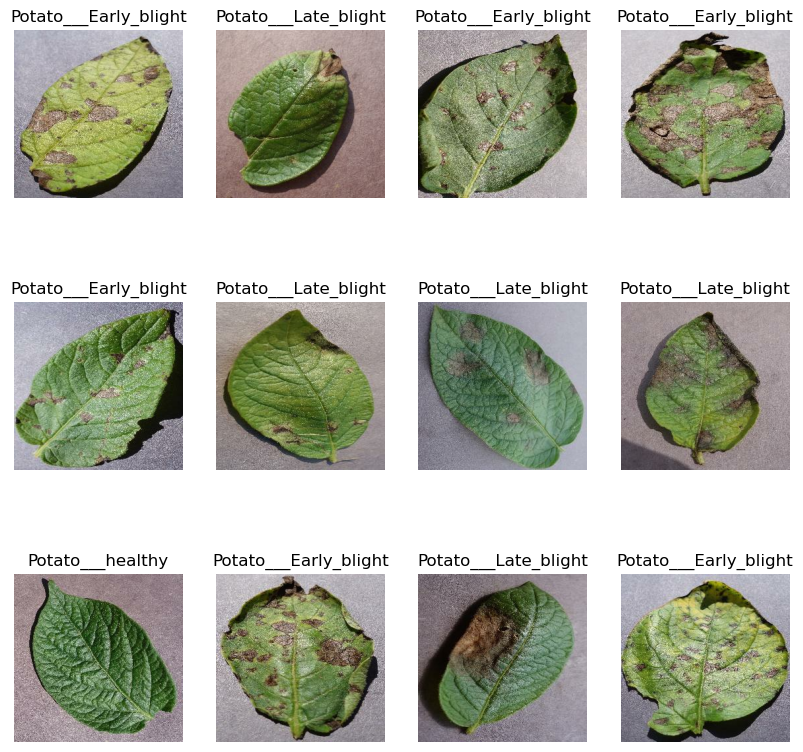

In [20]:
plt.figure(figsize = (10, 10))

for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [21]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [23]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [25]:
len(train_ds)

54

In [26]:
len(test_ds)

8

In [27]:
len(val_ds)

6

In [29]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [31]:
resize_and_rescale = tf.keras.Sequential([
    
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
    
])

In [32]:
data_augmentation = tf.keras.Sequential([
    
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
    
])

In [36]:
model = models.Sequential([
    
    resize_and_rescale,
    data_augmentation,
    
    layers.Conv2D(32, (3,3), activation = 'relu', input_shape = (32, 256, 256, 3)),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(3, activation = 'softmax')
    
])

model.build(input_shape = (32, 256, 256, 3))

c:\Users\husni\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [37]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_6 (Conv2D)               │ (32, 254, 254, 32)        │        896 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (32, 127, 127, 32)        │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_7 (Conv2D)               │ (32, 125, 125, 64)        │     18,496 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (32, 62, 62, 64)          │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_8 (Conv2D)               │ (32, 60, 60, 64)          │     36,928 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (32, 30, 30, 64)          │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_9 (Conv2D)               │ (32, 28, 28, 64)          │     36,928 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (32, 14, 14, 64)          │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_10 (Conv2D)              │ (32, 12, 12, 64)          │     36,928 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (32, 6, 6, 64)            │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_11 (Conv2D)              │ (32, 4, 4, 64)            │     36,928 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (32, 2, 2, 64)            │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten_1 (Flatten)             │ (32, 256)                 │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_2 (Dense)                 │ (32, 64)                  │     16,448 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_3 (Dense)                 │ (32, 3)                   │        195 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [40]:
model.compile(
              optimizer = 'adam',
              loss = tf.losses.SparseCategoricalCrossentropy(from_logits = False),
              metrics = ['accuracy']
)

In [41]:
history = model.fit(
    train_ds,
    epochs = 50,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 39s 581ms/step - accuracy: 0.4260 - loss: 0.9668 - val_accuracy: 0.5938 - val_loss: 0.8346
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 28s 515ms/step - accuracy: 0.6005 - loss: 0.8580 - val_accuracy: 0.7292 - val_loss: 0.6311
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 28s 527ms/step - accuracy: 0.7662 - loss: 0.5726 - val_accuracy: 0.6719 - val_loss: 0.6201
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 29s 533ms/step - accuracy: 0.8105 - loss: 0.4674 - val_accuracy: 0.8594 - val_loss: 0.3431
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 28s 517ms/step - accuracy: 0.8660 - loss: 0.3199 - val_accuracy: 0.8802 - val_loss: 0.2984
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 28s 519ms/step - accuracy: 0.8943 - loss: 0.2654 - val_accuracy: 0.8542 - val_loss: 0.3165
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 28s 517ms/step - accuracy: 0.8855 - loss: 0.2618 - val_accuracy: 0.8490 - val_loss: 0.3550
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 28s 510ms/step - accuracy: 0.9036 - loss: 0.2578 - val_accu

In [42]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - accuracy: 1.0000 - loss: 0.0159


In [44]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

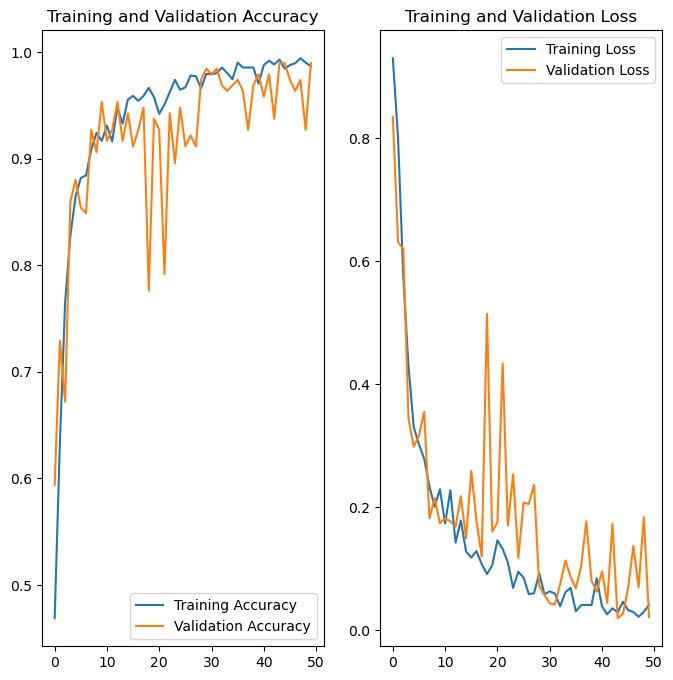

In [48]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(50), acc, label='Training Accuracy')
plt.plot(range(50), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(50), loss, label='Training Loss')
plt.plot(range(50), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label:  Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
Predicted Label: Potato___Late_blight


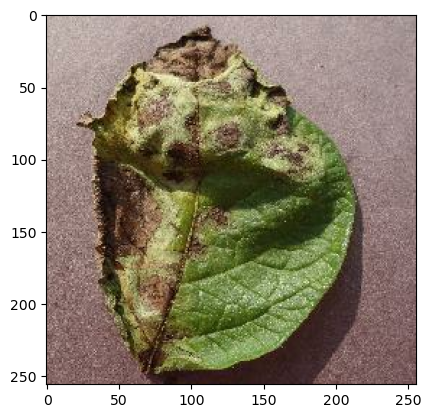

In [60]:

for images_batch, labels_batch in test_ds.take(1):
    
    first_image = image_batch[10].numpy().astype('uint8')
    first_label = labels_batch[10].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label: ", class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("Predicted Label:",class_names[np.argmax(batch_prediction[10])])

In [61]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


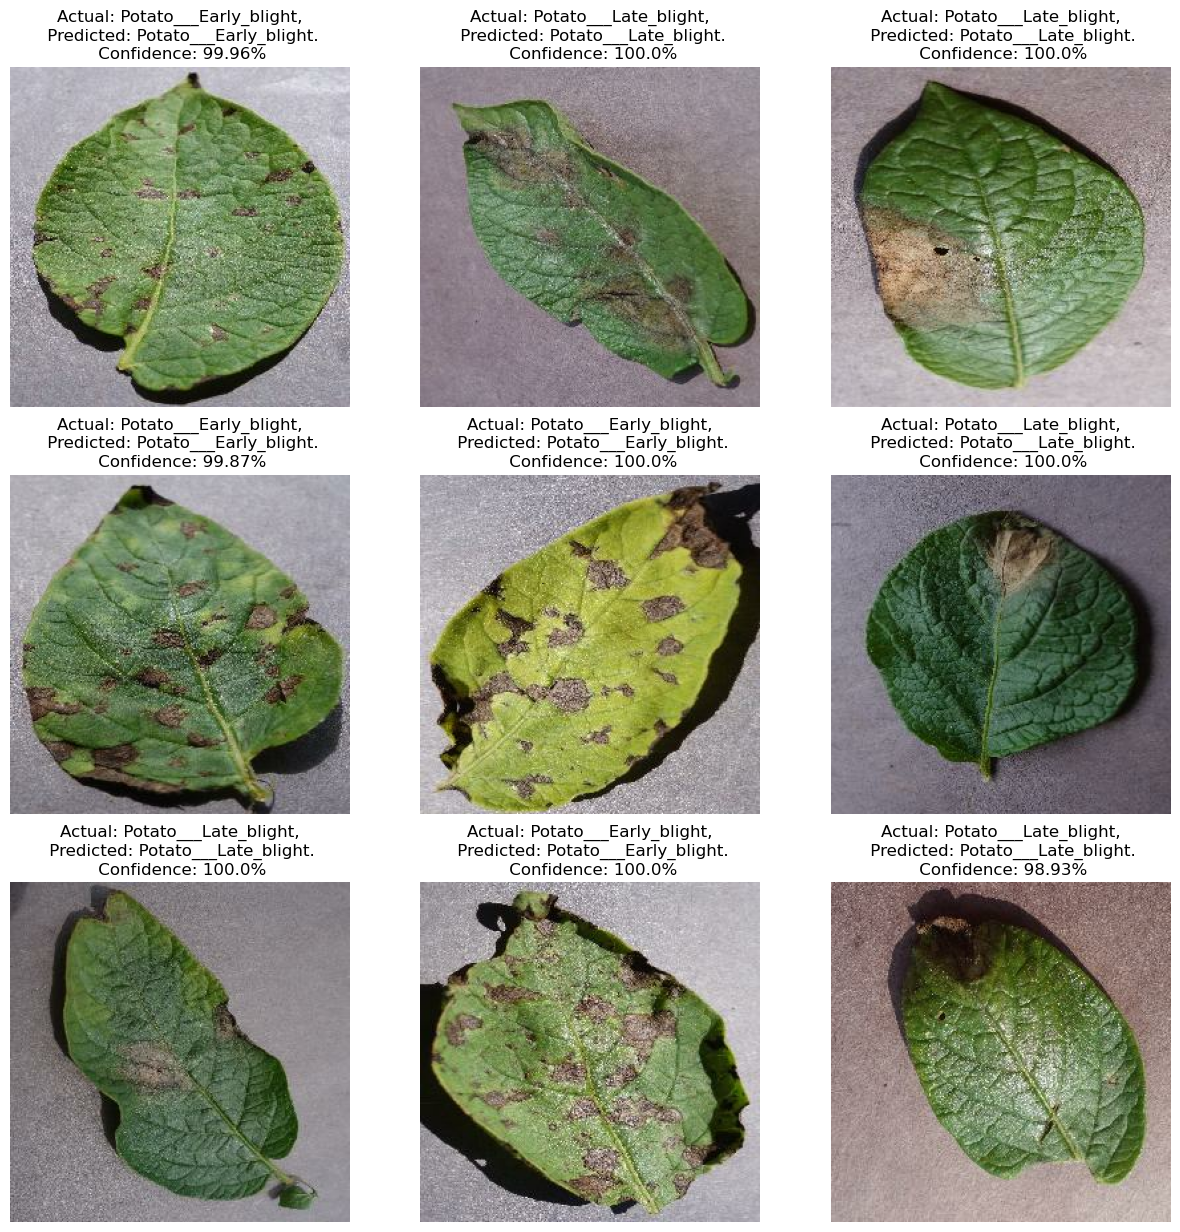

In [62]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [77]:
import os
model_version = max([int(i) for i in os.listdir("../models") if i.isdigit()] + [0]) + 1
model.save(f"../models/{model_version}.keras")